# EDA: Synthetic Dataset

해당 데이터셋은 인공적으로 만들어진 ECG와 PPG 신호를 제공한다. 이 신호들은 연구자들의 알고리즘이 이상적인 데이터에서 호흡수를 정확하게 평가하는지 확인하기 위해 생성되었다.

알고리즘이 합리적으로 구현되었는지 확인할 때 특히 유용하다. 본 데이터셋은 다양한 심박수(HR)과 호흡수(RR)를 아우르는 ECG, PPG 신호를 포함한다. 

각각의 HR과 RR에 대해 세 가지 신호 (Baseline wandering(BW), Amplitude modulation(AM), Frequency modulation(FM)) 가 선택적으로 조합되어 제공된다.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.signal_processing import signal_resample
%matplotlib inline
plt.style.use('ggplot')

DATALAKE_PATH = '../../DataLake/rrest-syn_csv'
regex = re.compile('rrest-syn[0-9]+')
syn_id = sorted(list(set([regex.match(filename.name).group() for filename in os.scandir(DATALAKE_PATH)])))
fs = 500

In [3]:
temp_resp = []
for i in range(len(syn_id)):
    with open(f'{DATALAKE_PATH}/{syn_id[i]}_fix.txt') as f:
        temp_resp.append(f.readlines()[-2])
    
temp_resp = np.asarray(temp_resp)

In [4]:
exp_resp = re.compile(r'\d+')
resp = list(map(lambda r: int(exp_resp.findall(r)[0]), temp_resp))

In [5]:
pleth = []
for i in range(len(syn_id)):
    sig_dat = pd.read_csv(f'{DATALAKE_PATH}/{syn_id[i]}_data.csv', header=None, names=['PLETH', 'ECG'])
    pleth.append(sig_dat.PLETH.values[500:100500])

pleth = np.asarray(pleth)
print(pleth.shape, len(resp))

(192, 100000) 192


## Filtering

In [ ]:
# Filtering

## Windowing

In [25]:
# Windowing
dataset = []
shift_factor = 3
window_size = fs * 60 # 30000
shift = int(window_size/shift_factor) # 10000
samples_len = len(pleth) # 196    

shift_n_times = int((pleth.shape[1]-window_size)/shift)
new_resp = np.repeat(resp, shift_n_times) # 192 * 7

for i in range(samples_len):
    sliced_pleth = [pleth[0+(shift*i):window_size+(shift*i)] for i in range(shift_n_times)]
    matched_resp = [resp[i]] * shift_n_times

    for i in range(shift_n_times):
        temp = []
        temp.append(sliced_pleth[0][i])
        temp.append(matched_resp[i])
        dataset.append(temp)

len(dataset) # 192*7

## Resampling

In [ ]:
# Resampling

---

In [9]:
test = pd.read_csv(f'{DATALAKE_PATH}/{syn_id[1]}_data.csv', header=None, names=['PLETH', 'ECG'])
test.shape

(105000, 2)

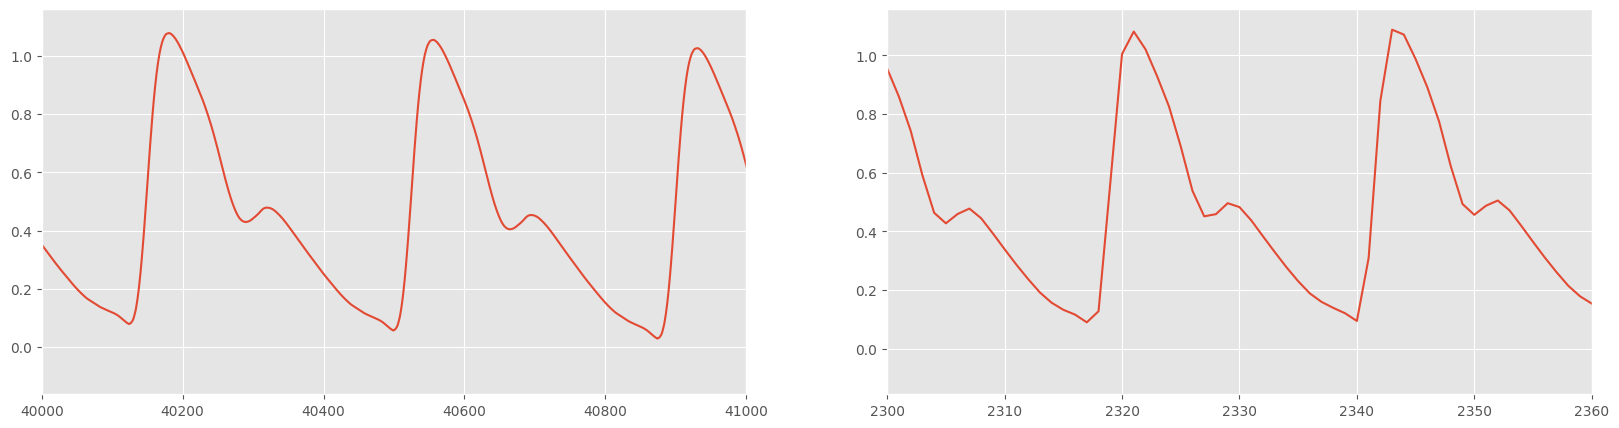

In [4]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(test.PLETH.values)
axs[0].set_xlim(40000, 41000)
axs[1].plot(signal_resample(test.PLETH.values, org_fs=500, new_fs=30, method='interpolation'))
axs[1].set_xlim(2300, 2360)
plt.show()